In [63]:
import dlib
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

In [64]:
def show_image(image):
    plt.imshow(image, cmap=plt.cm.gray)
    plt.axis('off')
    plt.show()

In [65]:
images = np.load('X_train.npy')
labels = np.load('y_train.npy')
images_reshaped = images.reshape(images.shape[0], 50, 37).astype('uint8')
images_reshaped

array([[[ 21,  24,  53, ...,  28,  28,  17],
        [ 21,  28,  62, ...,  31,  29,  18],
        [ 17,  34,  67, ...,  38,  34,  19],
        ..., 
        [128, 128, 131, ...,  34,  48,  68],
        [131, 129, 131, ...,  47,  69,  71],
        [131, 130, 130, ...,  70,  76,  83]],

       [[205, 209, 198, ..., 149, 150, 147],
        [201, 205, 189, ..., 148, 148, 147],
        [203, 202, 182, ..., 151, 151, 147],
        ..., 
        [ 27,  60, 175, ..., 126, 178, 215],
        [ 25,  31, 129, ..., 154, 211, 214],
        [ 27,  25,  82, ..., 197, 221, 212]],

       [[128, 140, 135, ..., 103,  48,  17],
        [132, 140, 134, ..., 109,  65,  15],
        [133, 141, 141, ..., 106,  90,  23],
        ..., 
        [210, 164, 129, ...,  95, 101,  94],
        [224, 213, 155, ..., 105, 107,  98],
        [224, 229, 209, ...,  74,  77,  73]],

       ..., 
       [[ 63, 103, 119, ..., 137, 142, 131],
        [ 79, 111, 125, ..., 143, 138, 142],
        [ 90, 122, 134, ..., 148, 139, 

In [66]:
# References:
# https://github.com/cmusatyalab/openface/blob/master/openface/align_dlib.py
# https://gist.github.com/ageitgey/82d0ea0fdb56dc93cb9b716e7ceb364b

TEMPLATE = np.float32([
    (0.0792396913815, 0.339223741112), (0.0829219487236, 0.456955367943),
    (0.0967927109165, 0.575648016728), (0.122141515615, 0.691921601066),
    (0.168687863544, 0.800341263616), (0.239789390707, 0.895732504778),
    (0.325662452515, 0.977068762493), (0.422318282013, 1.04329000149),
    (0.531777802068, 1.06080371126), (0.641296298053, 1.03981924107),
    (0.738105872266, 0.972268833998), (0.824444363295, 0.889624082279),
    (0.894792677532, 0.792494155836), (0.939395486253, 0.681546643421),
    (0.96111933829, 0.562238253072), (0.970579841181, 0.441758925744),
    (0.971193274221, 0.322118743967), (0.163846223133, 0.249151738053),
    (0.21780354657, 0.204255863861), (0.291299351124, 0.192367318323),
    (0.367460241458, 0.203582210627), (0.4392945113, 0.233135599851),
    (0.586445962425, 0.228141644834), (0.660152671635, 0.195923841854),
    (0.737466449096, 0.182360984545), (0.813236546239, 0.192828009114),
    (0.8707571886, 0.235293377042), (0.51534533827, 0.31863546193),
    (0.516221448289, 0.396200446263), (0.517118861835, 0.473797687758),
    (0.51816430343, 0.553157797772), (0.433701156035, 0.604054457668),
    (0.475501237769, 0.62076344024), (0.520712933176, 0.634268222208),
    (0.565874114041, 0.618796581487), (0.607054002672, 0.60157671656),
    (0.252418718401, 0.331052263829), (0.298663015648, 0.302646354002),
    (0.355749724218, 0.303020650651), (0.403718978315, 0.33867711083),
    (0.352507175597, 0.349987615384), (0.296791759886, 0.350478978225),
    (0.631326076346, 0.334136672344), (0.679073381078, 0.29645404267),
    (0.73597236153, 0.294721285802), (0.782865376271, 0.321305281656),
    (0.740312274764, 0.341849376713), (0.68499850091, 0.343734332172),
    (0.353167761422, 0.746189164237), (0.414587777921, 0.719053835073),
    (0.477677654595, 0.706835892494), (0.522732900812, 0.717092275768),
    (0.569832064287, 0.705414478982), (0.635195811927, 0.71565572516),
    (0.69951672331, 0.739419187253), (0.639447159575, 0.805236879972),
    (0.576410514055, 0.835436670169), (0.525398405766, 0.841706377792),
    (0.47641545769, 0.837505914975), (0.41379548902, 0.810045601727),
    (0.380084785646, 0.749979603086), (0.477955996282, 0.74513234612),
    (0.523389793327, 0.748924302636), (0.571057789237, 0.74332894691),
    (0.672409137852, 0.744177032192), (0.572539621444, 0.776609286626),
    (0.5240106503, 0.783370783245), (0.477561227414, 0.778476346951)])

TPL_MIN, TPL_MAX = np.min(TEMPLATE, axis=0), np.max(TEMPLATE, axis=0)
MINMAX_TEMPLATE = (TEMPLATE - TPL_MIN) / (TPL_MAX - TPL_MIN)
OUTER_EYES_AND_NOSE = [36, 45, 33]

predictor_model = "shape_predictor_68_face_landmarks.dat"

predictor = dlib.shape_predictor(predictor_model)
detector = dlib.get_frontal_face_detector()
np_landmark_indices = np.array(OUTER_EYES_AND_NOSE)

def get_aligned_faces(image, img_dim=50):
    detected_faces = detector(image, 1)
    aligned_faces = []
    
    for i, face_rect in enumerate(detected_faces):
        print("Face #{} found at Left: {} Top: {} Right: {} Bottom: {}".format(i, face_rect.left(), face_rect.top(), face_rect.right(), face_rect.bottom()))
        landmarks = predictor(image, face_rect)

        np_landmarks = np.float32(list(map(lambda p: (p.x, p.y), landmarks.parts())))
        
        H = cv2.getAffineTransform(np_landmarks[np_landmark_indices],
                                   img_dim * MINMAX_TEMPLATE[np_landmark_indices])
    
        thumbnail = cv2.warpAffine(image, H, (img_dim, img_dim))
        aligned_faces.append(thumbnail)
        
    return aligned_faces

In [5]:
aligned_images = []
filtered_labels = []
count = 0
for idx, image in enumerate(images_reshaped):
    faces = get_aligned_faces(image)
    if faces:
        aligned_images.append(faces[0])
        filtered_labels.append(labels[idx])
    else:
        count+=1
        print(idx)
print(count)

Face #0 found at Left: -7 Top: 6 Right: 33 Bottom: 42
Face #0 found at Left: -7 Top: 6 Right: 33 Bottom: 42
Face #0 found at Left: -8 Top: 2 Right: 40 Bottom: 45
Face #0 found at Left: 5 Top: 6 Right: 41 Bottom: 42
Face #0 found at Left: 5 Top: 6 Right: 41 Bottom: 42
Face #0 found at Left: 1 Top: 10 Right: 37 Bottom: 46
Face #0 found at Left: -13 Top: 2 Right: 35 Bottom: 45
Face #0 found at Left: -8 Top: 2 Right: 40 Bottom: 45
Face #0 found at Left: -8 Top: 7 Right: 40 Bottom: 50
Face #0 found at Left: -8 Top: 2 Right: 40 Bottom: 45
Face #0 found at Left: -7 Top: 6 Right: 33 Bottom: 42
Face #0 found at Left: -7 Top: 10 Right: 33 Bottom: 46
Face #0 found at Left: -13 Top: 2 Right: 35 Bottom: 45
13
Face #0 found at Left: 1 Top: 10 Right: 37 Bottom: 46
Face #0 found at Left: -8 Top: 2 Right: 40 Bottom: 45
Face #0 found at Left: -7 Top: 6 Right: 33 Bottom: 42
Face #0 found at Left: -8 Top: 7 Right: 40 Bottom: 50
Face #0 found at Left: -8 Top: 2 Right: 40 Bottom: 45
Face #0 found at Left: 1

In [6]:
np_aligned_images = np.array(aligned_images).reshape(len(aligned_images), 50*50)
np.save("X_train_aligned.npy", np_aligned_images)
np.save("y_train_aligned.npy", np.array(filtered_labels))

In [7]:
test_images = np.load('X_test.npy')
test_images_reshaped = test_images.reshape(test_images.shape[0], 50, 37).astype('uint8')
test_images_reshaped

array([[[ 64,  57,  57, ...,  65,  62,  52],
        [ 83,  76,  71, ...,  66,  60,  56],
        [ 83,  80,  75, ...,  70,  61,  59],
        ..., 
        [108, 104, 104, ..., 158, 208,  88],
        [115, 118, 114, ..., 162, 216,  96],
        [113, 123, 120, ..., 163, 215, 104]],

       [[  6,   7,  38, ..., 168, 164, 161],
        [  7,  10,  44, ..., 159, 149, 144],
        [  8,   9,  35, ..., 140, 136, 135],
        ..., 
        [ 27,  39, 134, ..., 200, 210, 212],
        [ 27,  33, 130, ..., 203, 211, 216],
        [ 27,  29, 118, ..., 205, 211, 217]],

       [[ 54,  59,  53, ..., 107, 106, 103],
        [ 58,  59,  51, ...,  88,  93,  91],
        [ 62,  56,  54, ...,  69,  71,  76],
        ..., 
        [ 31,  30,  29, ..., 201, 236, 240],
        [ 31,  30,  29, ..., 229, 234, 236],
        [ 31,  30,  28, ..., 228, 230, 233]],

       ..., 
       [[117, 105,  94, ..., 127, 136, 149],
        [115, 102, 102, ..., 137, 131, 149],
        [118, 114, 120, ..., 151, 135, 

In [8]:
aligned_test_images = []
missing_idx = []
count = 0
for idx, image in enumerate(test_images_reshaped):
    faces = get_aligned_faces(image)
    if faces:
        aligned_test_images.append(faces[0])
    else:
        count+=1
        missing_idx.append(idx)
        print(idx)
print(count)

Face #0 found at Left: -8 Top: 2 Right: 40 Bottom: 45
Face #0 found at Left: -8 Top: 2 Right: 40 Bottom: 45
Face #0 found at Left: -13 Top: 2 Right: 35 Bottom: 45
Face #0 found at Left: -13 Top: 2 Right: 35 Bottom: 45
Face #0 found at Left: -7 Top: 6 Right: 33 Bottom: 42
Face #0 found at Left: 1 Top: 6 Right: 37 Bottom: 42
Face #0 found at Left: -8 Top: 2 Right: 40 Bottom: 45
Face #0 found at Left: -8 Top: 2 Right: 40 Bottom: 45
Face #0 found at Left: 1 Top: 10 Right: 37 Bottom: 46
Face #0 found at Left: 1 Top: 10 Right: 37 Bottom: 46
Face #0 found at Left: -8 Top: 2 Right: 40 Bottom: 45
Face #0 found at Left: -8 Top: 2 Right: 40 Bottom: 45
Face #0 found at Left: 2 Top: 2 Right: 45 Bottom: 45
Face #0 found at Left: -7 Top: 10 Right: 33 Bottom: 46
Face #0 found at Left: -8 Top: 2 Right: 40 Bottom: 45
Face #0 found at Left: -8 Top: 2 Right: 40 Bottom: 45
Face #0 found at Left: 1 Top: 10 Right: 37 Bottom: 46
Face #0 found at Left: -8 Top: 7 Right: 40 Bottom: 50
Face #0 found at Left: 1 To

In [9]:
np_aligned_test_images = np.array(aligned_test_images).reshape(len(aligned_test_images), 50*50)
np.save("X_test_aligned.npy", np_aligned_test_images)

In [10]:
missing_idx

[25, 85, 104, 106, 125, 131, 180, 202, 211, 233, 238, 244, 279, 283, 304, 309]

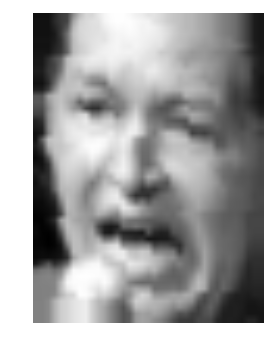

Face #0 found at Left: -7 Top: 6 Right: 33 Bottom: 42


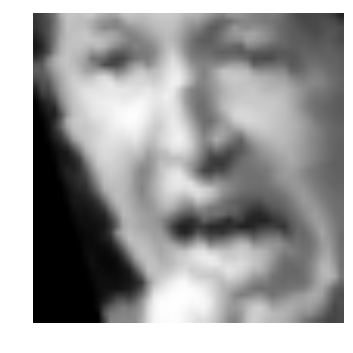

In [80]:
h = 50
w = 37

def shapeData(data, h=h, w=w):
    return data.reshape(data.shape[0], 1, h, w).astype('float32')


images_reshaped_float = shapeData(images)

datagen = ImageDataGenerator(shear_range=0.2,
                             zoom_range=0.2,
                             rotation_range=10)
datagen.fit(images_reshaped_float)

new_data = []  # store new images
new_label = []  # store the lable of new images
number_of_batches = 10
batches = 0

for X_batch, Y_batch in datagen.flow(images_reshaped_float[:1], labels[:1], batch_size=10):
    new_data.append(X_batch)
    new_label.append(Y_batch)
    batches += 1
    if batches >= number_of_batches:
        break

for image in new_data[0]:
    show_image(image[0])
    show_image(get_aligned_faces(image[0].astype('uint8'))[0])